In [1]:
import os
import numpy as np
from dotenv import load_dotenv
import pandas as pd


load_dotenv()
hf_token = os.getenv("HF_TOKEN")

In [2]:
NAME = 'kl_div'

df_gemma = pd.read_parquet("./data/gemma_att_kl_0_7000_df.parquet")
df_cnn = pd.read_parquet("./data/cnn_att_kl_0_1000_df.parquet")
df_xsum = pd.read_parquet("./data/xsum_kl_0_1000_df.parquet")

# df_cnn = pd.DataFrame()
# df_xsum = pd.DataFrame()

In [3]:
# df_gemma = pd.DataFrame()

# for file in os.listdir("../"):
#     if file.startswith("gemma_att_diff_mean") and file.endswith(".parquet"):
#         df_gemma = pd.concat([df_gemma, pd.read_parquet(f"../{file}")])

# df_gemma.to_parquet("../data/gemma_att_diff_df.parquet")
# df_gemma.shape

In [4]:
# df_cnn = pd.DataFrame()

# for file in os.listdir("../"):
#     if file.startswith("cnn_att_diff_mean") and file.endswith(".parquet"):
#         df_cnn = pd.concat([df_cnn, pd.read_parquet(f"../{file}")])

# df_cnn.to_parquet("../data/cnn_att_diff_df.parquet")
# df_cnn.shape

In [5]:
# from ydata_profiling import ProfileReport

# df_gemma_eda = df_gemma.drop(['dataset'], axis=1)
# # Create a profile report
# profile = ProfileReport(
#     df_gemma_eda, 
#     title="Gemma DataFrame Profiling Report",
#     correlations={
#         "chi_squared": {"calculate": False},
#     }

# )
# # To display the report in a Jupyter Notebook
# profile.to_notebook_iframe()

In [6]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix


In [7]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import IsolationForest
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from imblearn.under_sampling import RandomUnderSampler

In [8]:
pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Scale the data
            ('undersampler', RandomUnderSampler(random_state=42)),  # Undersample the majority class
            ('model', LGBMClassifier(n_jobs=-1, random_state=42))  # Train a model
        ])

[LightGBM] [Info] Number of positive: 166, number of negative: 166
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4424
[LightGBM] [Info] Number of data points in the train set: 332, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 260409 (hallucination). Use `wandb login --relogin` to force relogin


test_auc_mean,▁
test_auc_std,▁
test_auprc_mean,▁
test_auprc_std,▁
train_auc_mean,▁
train_auc_std,▁
train_auprc_mean,▁
train_auprc_std,▁
validation_auc_mean,▁
validation_auc_std,▁
validation_auprc_mean,▁


[LightGBM] [Info] Number of positive: 778, number of negative: 778
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 1556, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 778, number of negative: 778
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 1556, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 778, number of negative: 778
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the o

test_auc_mean,▁
test_auc_std,▁
test_auprc_mean,▁
test_auprc_std,▁
train_auc_mean,▁
train_auc_std,▁
train_auprc_mean,▁
train_auprc_std,▁
validation_auc_mean,▁
validation_auc_std,▁
validation_auprc_mean,▁


[LightGBM] [Info] Number of positive: 1384, number of negative: 1384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 2768, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1384, number of negative: 1384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 2768, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1384, number of negative: 1384
[LightGBM] [Info] Auto-choosing col-wise multi-threading,

test_auc_mean,▁
test_auc_std,▁
test_auprc_mean,▁
test_auprc_std,▁
train_auc_mean,▁
train_auc_std,▁
train_auprc_mean,▁
train_auprc_std,▁
validation_auc_mean,▁
validation_auc_std,▁
validation_auprc_mean,▁


[LightGBM] [Info] Number of positive: 657, number of negative: 657
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 658, number of negative: 658
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 1316, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 658, number of negative: 658
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the o

test_auc_mean,▁
test_auc_std,▁
test_auprc_mean,▁
test_auprc_std,▁
train_auc_mean,▁
train_auc_std,▁
train_auprc_mean,▁
train_auprc_std,▁
validation_auc_mean,▁
validation_auc_std,▁
validation_auprc_mean,▁


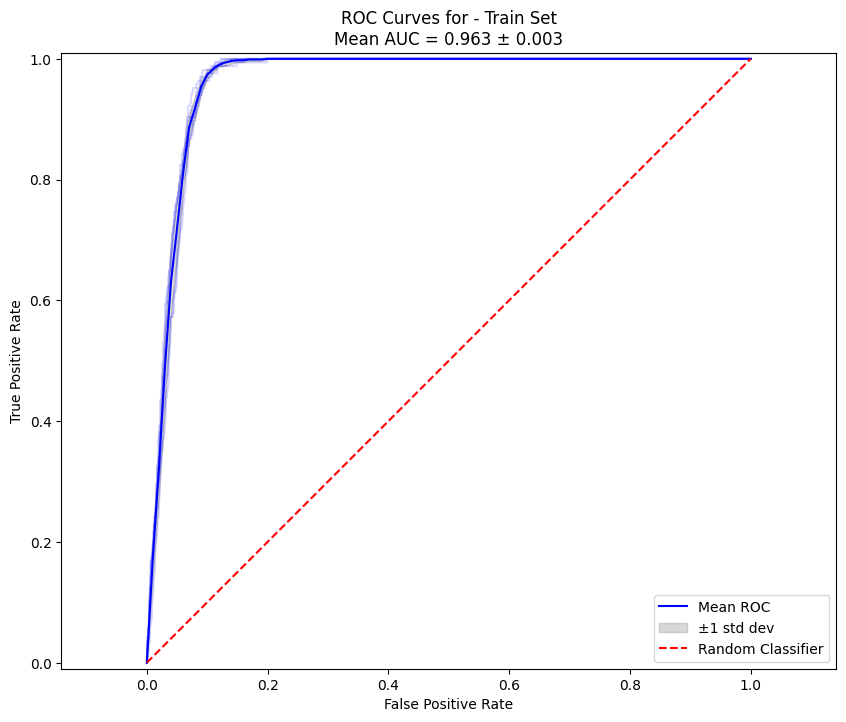

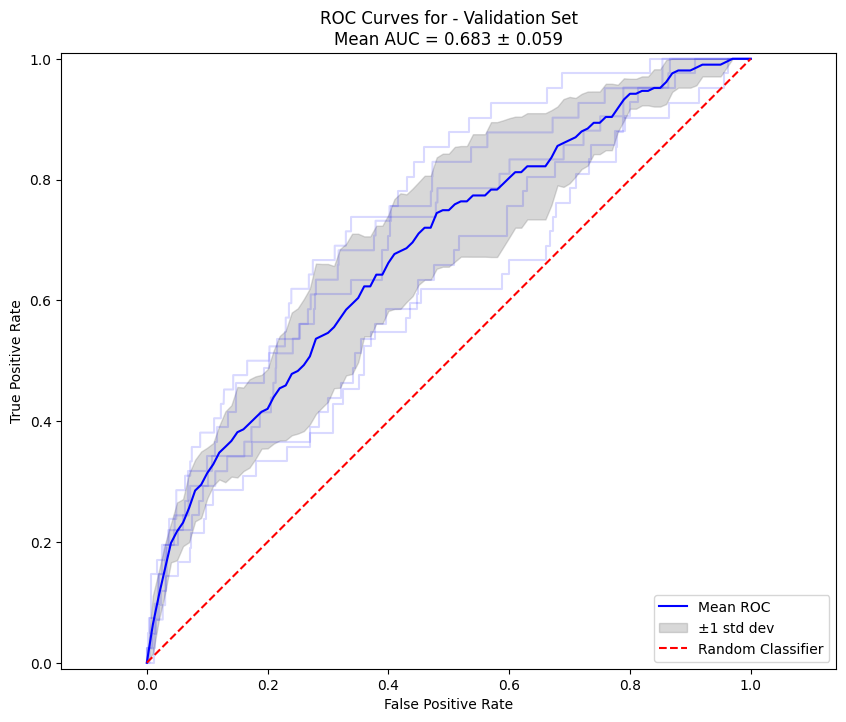

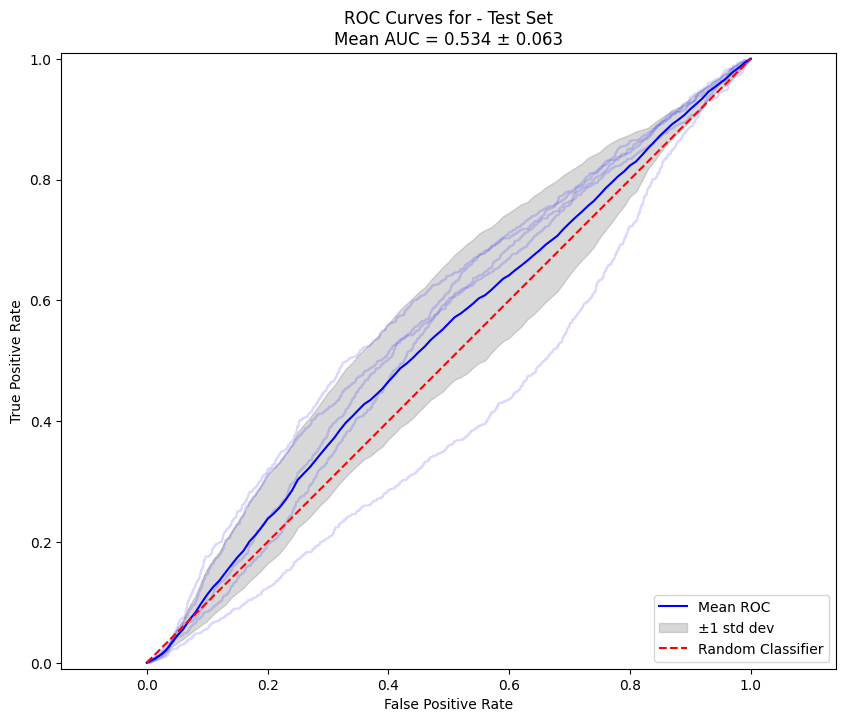

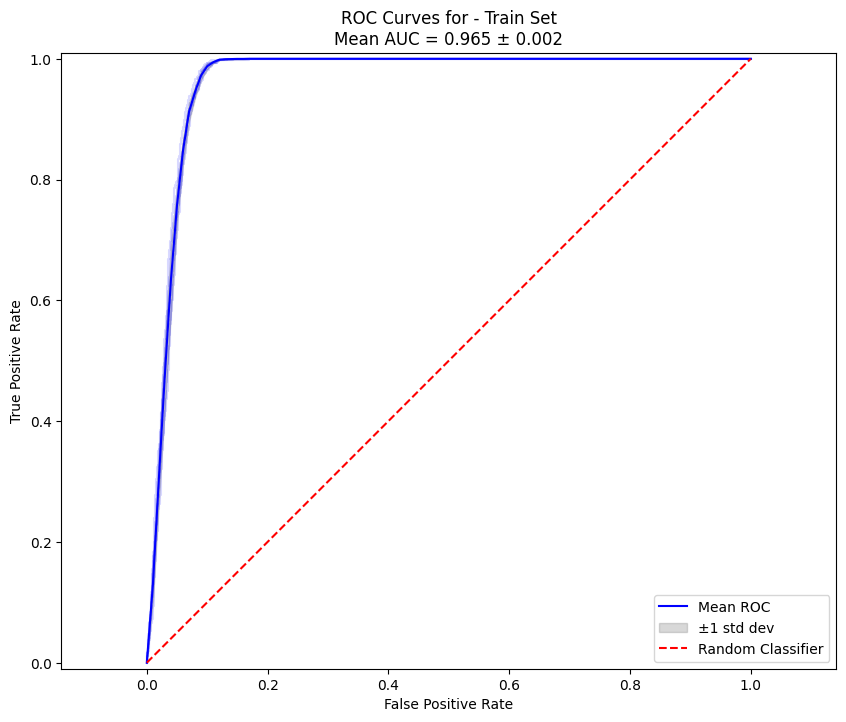

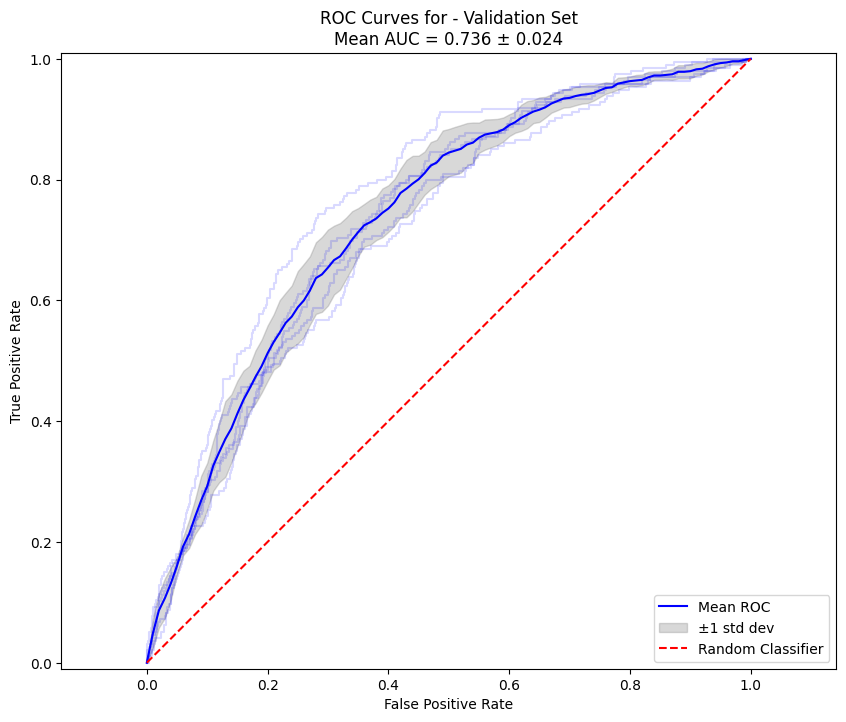

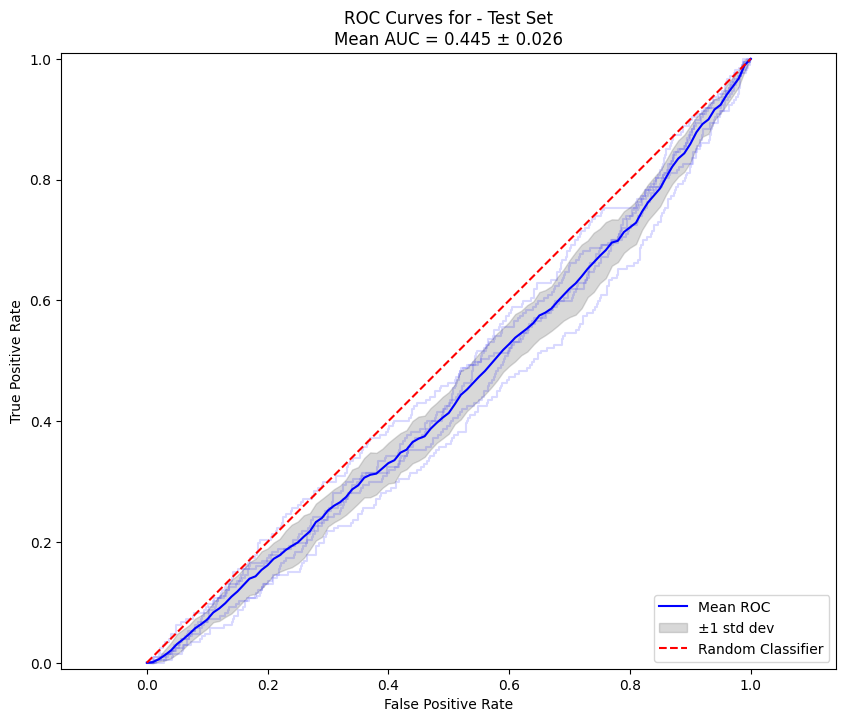

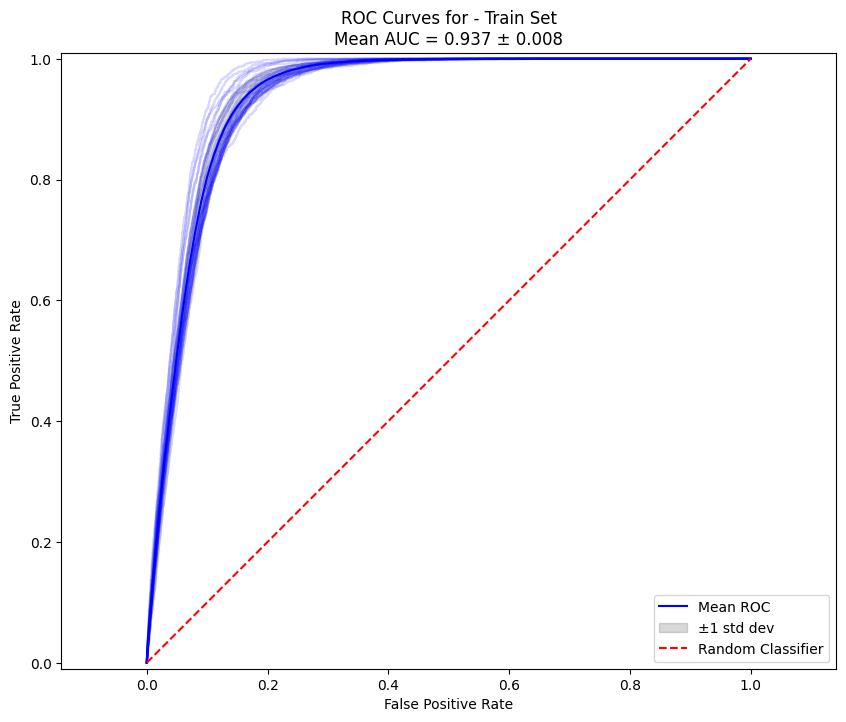

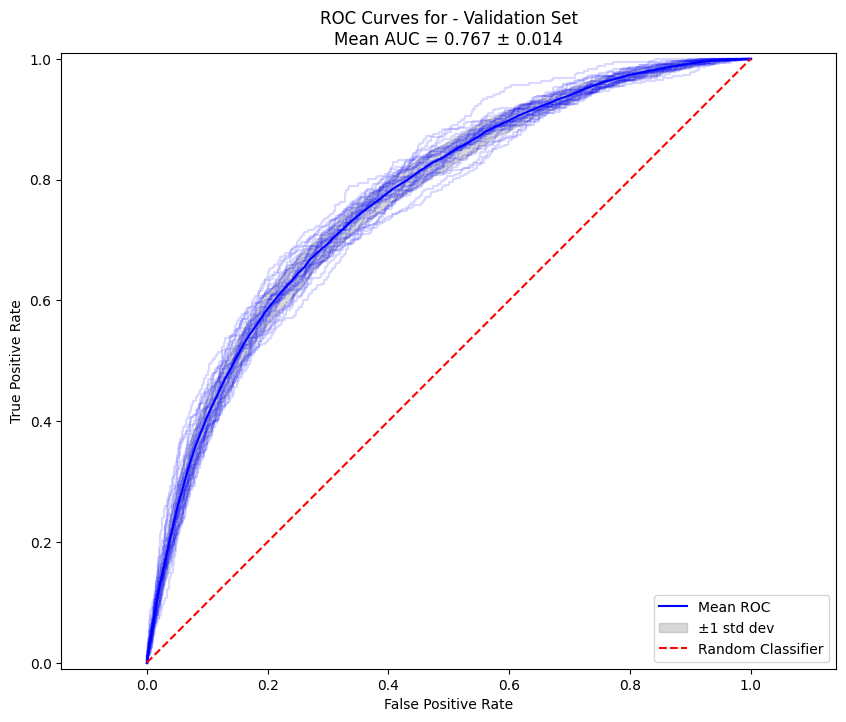

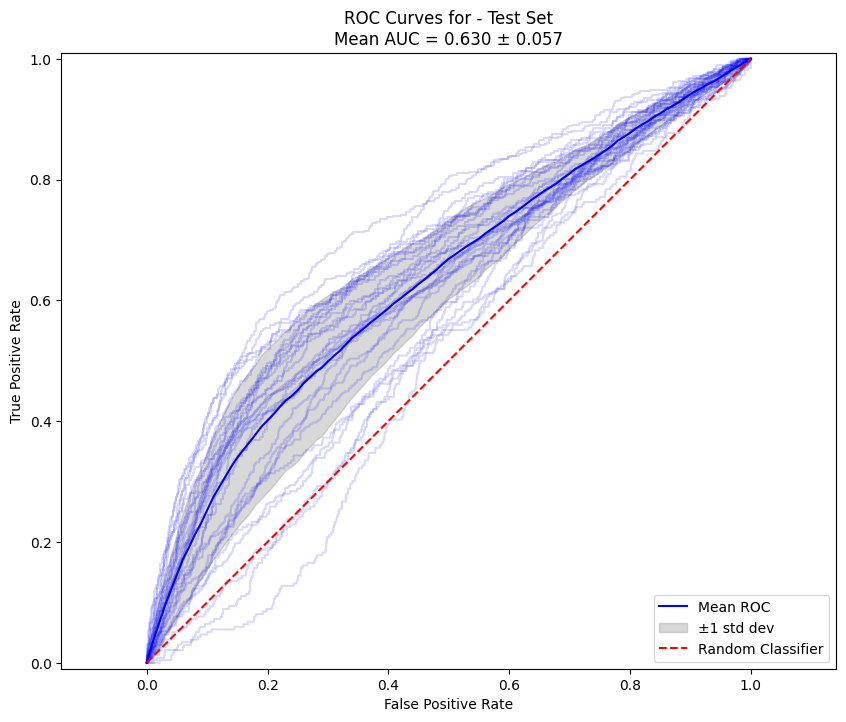

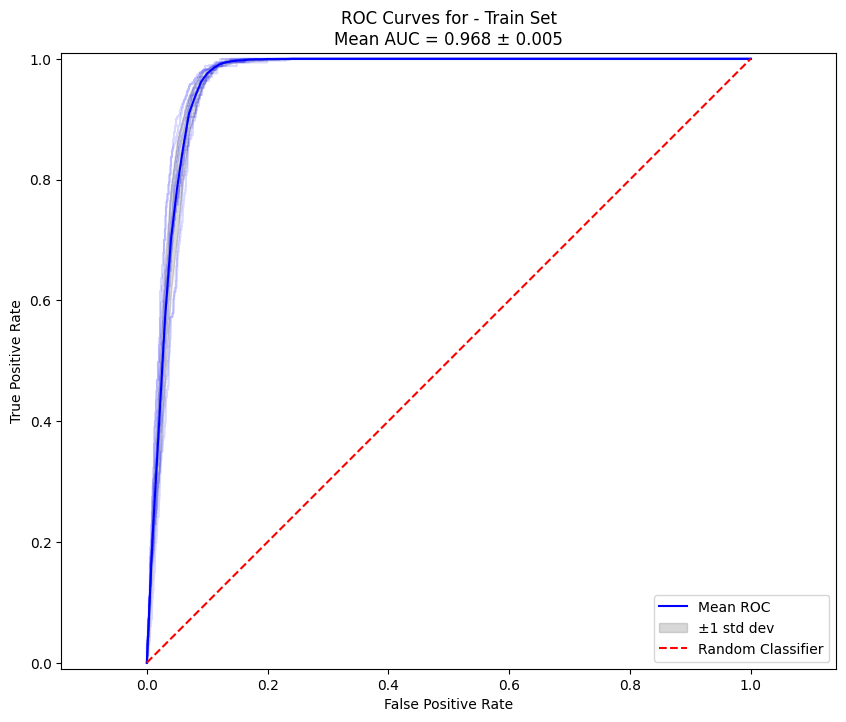

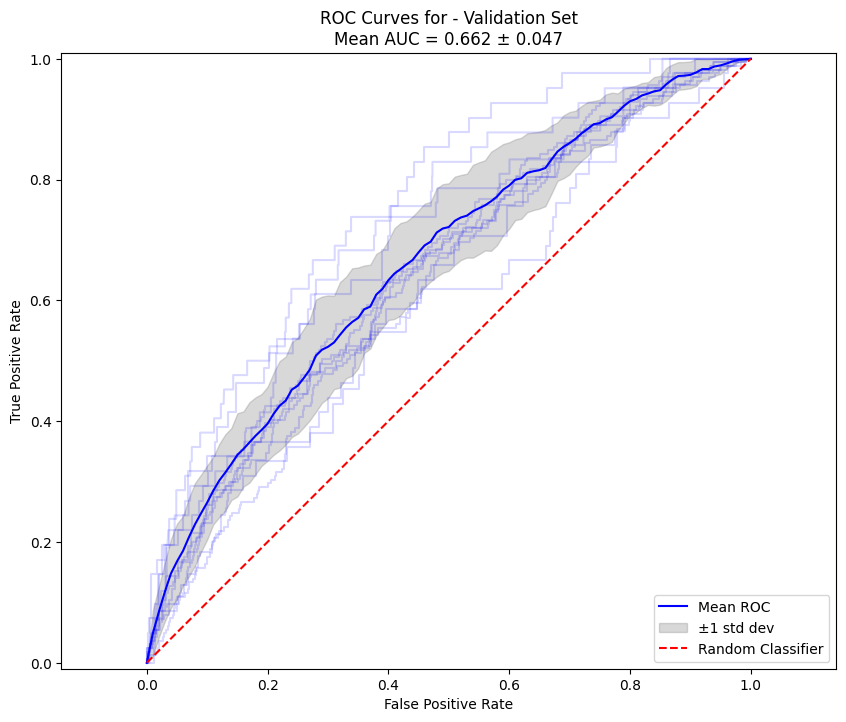

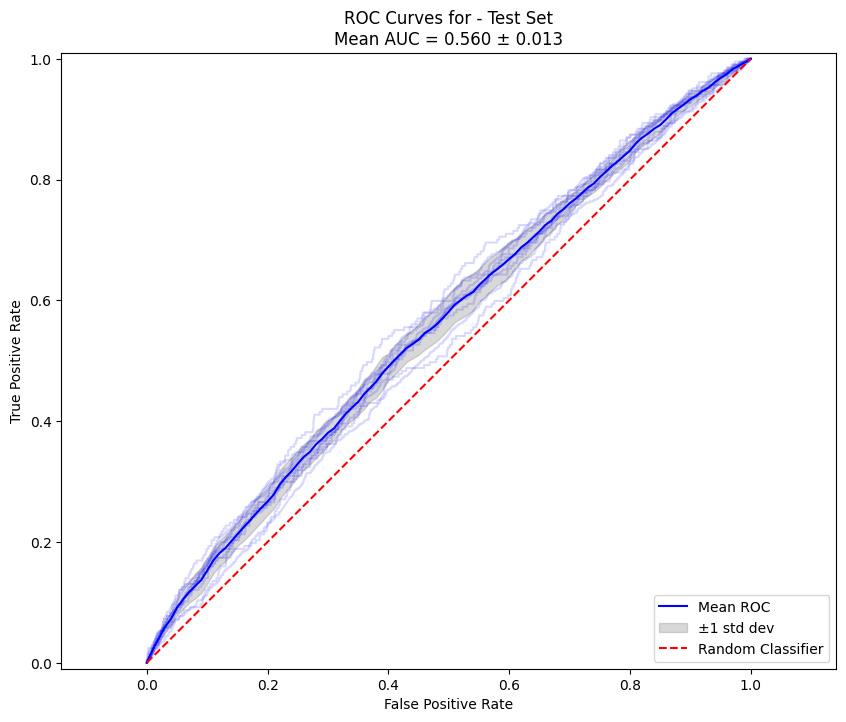

In [ ]:
from golemai.ml.sklearn_auto_trainer import SklearnAutoTrainer

trainer = SklearnAutoTrainer(
    project_name="hallu-sklearn",
)

df_all = pd.concat([df_gemma, df_cnn, df_xsum])



trainer.evaluate(
    pipeline,
    df_all,
    group_name=NAME,
    description="Test of kl divergence on all datasets",
)


In [10]:
# import torch
# from torch import nn
# from torch.utils.data import DataLoader, Dataset
# import lightning as L
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from torchmetrics.classification import AUROC
# from lightning.pytorch.callbacks import EarlyStopping

# # 1. Create a Synthetic Dataset
# class CustomDataset(Dataset):
#     def __init__(self, data, labels):
#         self.data = data
#         self.labels = labels

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)


# # 2. Define the LSTM Model
# class LSTMModel(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
#         super().__init__()
#         self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)
#         self.hidden_dim = hidden_dim

#     def forward(self, x):
#         x = x.unsqueeze(1)  # (batch_size, seq_len, input_dim)
#         _, (hn, _) = self.lstm(x)  # hn is (num_layers, batch_size, hidden_dim)
#         out = self.fc(hn[-1])  # Use the last layer's hidden state
#         return out

# # 3. Create the Lightning Module
# class LSTMClassifier(L.LightningModule):
#     def __init__(self, input_dim, hidden_dim, output_dim, lr=5e-4, num_layers=1):
#         super().__init__()
#         self.model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers=num_layers)
#         self.criterion = nn.CrossEntropyLoss()
#         self.lr = lr

#         # AUROC metric for binary classification
#         self.train_auc = AUROC(task="binary")
#         self.val_auc = AUROC(task="binary")

#     def forward(self, x):
#         return self.model(x)

#     def training_step(self, batch, batch_idx):
#         data, labels = batch
#         preds = self(data)
#         loss = self.criterion(preds, labels)
#         # Calculate AUC during training
#         prob = torch.softmax(preds, dim=1)[:, 1]  # Take probabilities for class 1
#         auc = self.train_auc(prob, labels)
#         self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
#         self.log("train_auc", auc, on_step=False, on_epoch=True, prog_bar=True)
#         return loss

#     def validation_step(self, batch, batch_idx):
#         data, labels = batch
#         preds = self(data)
#         loss = self.criterion(preds, labels)
#         # Calculate AUC during validation
#         prob = torch.softmax(preds, dim=1)[:, 1]  # Take probabilities for class 1
#         auc = self.val_auc(prob, labels)
#         self.log("val_loss", loss, prog_bar=True)
#         self.log("val_auc", auc, prog_bar=True)
#         return loss

#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters(), lr=self.lr)




In [11]:
# from sklearn.preprocessing import RobustScaler


# X_train = df_gemma.drop(columns=['label', 'dataset'])
# y_train = df_gemma['label']

# X_val = df_cnn.drop(columns=['label', 'dataset'])
# y_val = df_cnn['label']

# scaler = RobustScaler()

# X_train_normalized = scaler.fit_transform(X_train)

# X_val_normalized = scaler.transform(X_val)

# train_dataset = CustomDataset(X_train_normalized, y_train)
# val_dataset = CustomDataset(X_val_normalized, y_val)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# # 4. Train the Model
# input_dim = X_train.shape[1]
# hidden_dim = 512
# output_dim = 2


# model = LSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, lr=5e-4, num_layers=3)

# # 1. Set up EarlyStopping callback
# early_stop_callback = EarlyStopping(
#     monitor="val_loss",  # The metric to monitor
#     patience=3,          # Number of epochs with no improvement after which training will stop
#     verbose=True,        # Display a message when stopping
#     mode="min",          # Minimize the monitored metric (for loss)
# )

# # 2. Initialize the Trainer with the early stopping callback
# trainer = L.Trainer(
#     max_epochs=100,
#     accelerator="gpu" if torch.cuda.is_available() else "cpu",
#     log_every_n_steps=10,
#     callbacks=[early_stop_callback],  # Add the early stopping callback here
# )

# # 3. Start the training
# trainer.fit(model, train_loader, val_loader)

